In [1]:
import numpy as np
# from tqdm import tdqm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
from PIL import Image

from tqdm import tqdm, trange
import torch

import torchvision.transforms as transforms


from MyViT.ViT import *




np.random.seed(0)
torch.manual_seed(0)
print(torch.backends.mps.is_available())
mps_device = torch.device("mps")
print(mps_device)

True
mps


In [2]:
import PIL
from PIL import Image
import numpy as np
import os
import random 
import pandas as pd
# open method used to open different extension image file
TRAIN_DATA_FOLDER = "data/train"
train_tumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/tumor/')
num_train_tumor_files = len(train_tumor_filenames)
print("Number of Training Tumor Files: ", num_train_tumor_files)

train_notumor_filenames = os.listdir(f'{TRAIN_DATA_FOLDER}/notumor/')
num_train_notumor_files = len(train_notumor_filenames)
print("Number of Training No Tumor Files: ", num_train_notumor_files)

Number of Training Tumor Files:  1339
Number of Training No Tumor Files:  1595


## Transformer Model Architecture
![Transformer Model](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*tA7xE2dQA_dfzA0Bub5TVw.png)

## Resizing Image

### Formula [e.g (N,1,28,28)] 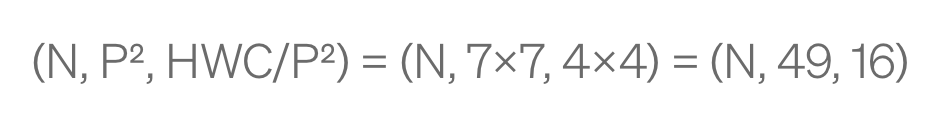
![Reshaping Image](https://miro.medium.com/v2/resize:fit:822/format:webp/1*CFbOxEuvo-Pgq7ETIrt0Eg.png)


### Positional Embedding
![Positional Embedding Formula](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lpRYHE0XjVkxRVKFrWkzuw.png)

In [7]:
def main():

    train_dataset = MRIDataset('data/train/', transform=ToTensor(),image_shape = 28)
    train_loader  = DataLoader(train_dataset, shuffle=True, batch_size=64)

    test_dataset = MRIDataset('data/test/', transform=ToTensor(),image_shape = 28)
    test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=64)
    # transform = ToTensor()
    # train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    # test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    # train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    # test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    IMAGE_SIZE = (1,28,28)
    NUM_PATCHES = 7

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    # print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available else "")
    model = MyViT(IMAGE_SIZE, n_patches=NUM_PATCHES, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

    N_EPOCHS = 5
    LR = 0.005

    # Training Loop
    optimizer = Adam(model.parameters(),lr = LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS,desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader,desc=f"Epoch{epoch+1} in training", leave=False):
            x,y = batch
            # print(y.shape)
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            train_loss += loss.detach().cpu().item()/len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{N_EPOCHS} loss: {train_loss:.2f}")

    with torch.no_grad():
        correct,total = 0,0
        test_loss = 0.0
        for batch in tqdm(test_loader,desc="Testing"):
            x,y = batch
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat,y)
            test_loss += loss.detach().cpu().item()/len(test_loader)

            correct += torch.sum(torch.argmax(y_hat,dim=1) == y).detach().cpu()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")




# Multi-Self Attention Class

In [4]:
from MyViT.ViT import * 
from MyViT.utils import MRIDataset,get_positional_embeddings,patchify

if __name__ == '__main__':
    main()

Training:  33%|███▎      | 1/3 [00:38<01:16, 38.32s/it]

Epoch 1/3 loss: 2.02


Training:  67%|██████▋   | 2/3 [01:19<00:40, 40.00s/it]

Epoch 2/3 loss: 1.92


Training: 100%|██████████| 3/3 [01:59<00:00, 39.97s/it]


Epoch 3/3 loss: 1.91


Testing: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]

Test loss: 1.86
Test accuracy: 56.96%
